In [1]:
import random
import imageio
import numpy as np
from PIL import Image
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.models import Sequential, Model

## Misc

In [2]:
# todo: apply to classes
def make_trainable(net, val, lr=0.001):
    net.model.trainable = val
    for l in net.model.layers:
        l.trainable = val
    net.cmpile(lr)
    
def define_gan(generator, discriminator):
    # make weights in the discriminator not trainable
    discriminator.trainable = False
    # connect them
    model = Sequential()
    # add generator
    model.add(generator)
    # add the discriminator
    model.add(discriminator)
    # при замене оптимизатора всё слетает ???
    model.compile(loss='binary_crossentropy', optimizer='adam')
    return model

def fit_discriminator(discriminator, Data, epochs, lr=0.001):
    make_trainable(discriminator, True, lr=lr)
    #discriminator.trainable = True
    discriminator.fit(Data.x, Data.y, epochs=epochs, plot=True)
    
# Training GAN
def fit_gan(gan, Data, epochs):
    p = Plot('GAN_results')

    for i in range(epochs):
        V = Data.load_random(n_samples=64)
        print("Epoch %d" % i)
        generated = generator.predict(V)
        if i % 10 == 0:
            p.add_to_gif(generated, np.ones(V.shape[0]), title='Epoch %d' % i, alpha=1)
        #make_trainable(discriminator, False)
        print("Fitting GAN")
        gan.fit(V, np.ones(V.shape[0]), epochs=2)
        #make_trainable(discriminator, True)
        print("Fitting discriminator")
        discriminator.fit(generated, np.zeros(V.shape[0]), validation_split=None)
        discriminator.fit(Data.x, Data.y, validation_split=0.2)
    p.save_gif()
    gan.save('gan.h5')


## Data generation class

In [3]:
# To generate data
class Dataset():
    x = None
    y = None
    W = None
    
    def __init__(self):
        return
    
    def load_data(self, data_range=10):
        dots_x = []
        for i in range(data_range*20):
            x = random.uniform(-data_range, data_range)
            dots_x.append((x, x**2)) # square
            for j in range(5):
                dots_x.append((x, random.uniform(-data_range, data_range**2))) # less than square
                #dots_x.append((x**r, x**(2*r*(1+random.gauss(0.5, 0.25)/20)))) # more than square
        dots_x = np.array(dots_x)
        #dots_y = np.array([random.uniform(0.75, 1.2) if x[0]**2 == x[1] else random.uniform(0, 0.3) for x in dots_x])
        dots_y = np.array([1 if x[0]**2 == x[1] else 0 for x in dots_x])
        self.x, self.y = dots_x, dots_y
        return dots_x, dots_y
    
    def load_weights(self, default_weight=0.12):
        W = self.y.copy().astype(float)
        W[W == 0] = 0.12
        self.W = W
        return W
        
    @staticmethod
    def load_random(n_dim=5, n_samples=16):
        V = np.random.normal(size=(n_samples, n_dim))
        return V
    

## Image plotting class

In [4]:
# To plot images
class Plot:
    name = ""
    images = []
    threshold = 0.0
    
    def __init__(self, name, threshold=0.6):
        self.name = name
        self.threshold = threshold
        self.images = []
    
    @staticmethod
    def parabola_plot(ax, xrange):
        x = np.linspace(xrange, 1)
        y = x*x
        plt.plot(x, y)
    
    @staticmethod
    def dots_plot(ax, dots_x, dots_y, color):
        ax.scatter(dots_x, dots_y, color=color, alpha=0.15)
        plt.plot()
    
    def picture(self, dots, predictions, title='', alpha=0.3):
        predictions = predictions.reshape(predictions.shape[0])
        dots_x = dots.T[0]
        fig = plt.figure()
        ax1 = fig.add_subplot(111)
        ax1.set(title=title)
        #ax2 = ax1.twinx()
        plt.grid(axis='both')
        xrange = (dots_x.min()*1.1, dots_x.max()*1.1)
        self.parabola_plot(ax1, xrange)
        ax1.scatter(dots.T[0], dots.T[1], c=predictions, cmap='YlOrRd', alpha=alpha)
        
    def add_to_gif(self, dots_x, predictions, title='', alpha=0.3):
        self.picture(dots_x, predictions, title=title, alpha=alpha)
        plt.savefig(self.name+'.png')
        plt.close()
        image = Image.open(self.name+'.png')
        ar = np.asarray(image)
        self.images.append(ar)
        
    def save_gif(self):
        kargs = { 'duration': 0.2 }
        imageio.mimsave(self.name+'.gif', self.images, None, **kargs)
        

## Neural networks classes

In [5]:
# Classes for neural networks

# Generator
class Gen:
    model = None
    
    def __init__(self):
        model = Sequential([Dense(15, activation='relu', kernel_initializer='he_uniform', input_dim=5),
                            Dense(2, activation='linear')
        ])
        self.model = model
        
    def predict(self, dots_x):
        return self.model.predict(dots_x)
    
    def cmpile(self):
        return
    
# Discriminator
class Dsc:
    model = None
    
    def __init__(self):
        model = Sequential([Dense(25, activation='relu', kernel_initializer='he_uniform', input_dim=2),
                            Dense(1, activation='sigmoid')
        ])
        self.model = model
    
    def cmpile(self, lr=0.0001):
        self.model.compile(loss='binary_crossentropy',
                           optimizer=tf.keras.optimizers.Adam(lr),
                           metrics=['accuracy'])
        
    def fit(self, dots_x, dots_y, weights=None, epochs=1, validation_split=0.15, plot=False):
        if plot:
            img = Plot('discriminator_fit')
            for i in range(epochs):
                print("Epoch %d out of %d" % (i, epochs))
                self.model.fit(dots_x, 
                               dots_y, 
                               epochs=10, 
                               sample_weight=weights,
                               validation_split=validation_split)
                img.add_to_gif(dots_x, self.model.predict(dots_x), title='Epoch %d' % i)
            img.save_gif()                        
        else:
            self.model.fit(dots_x, 
                           dots_y, 
                           epochs=epochs, 
                           sample_weight=weights, 
                           validation_split=validation_split)
    
    def save(self, name='discriminator'):
        self.model.save(name+'.h5')
        
# ================= Raw classes, don't work ====================

"""class Gan:
    gen = None
    dsc = None
    model = None
    
    def __init__(self, gen, dsc, n_dim=5):
        make_trainable(dsc, False)
        self.gen = gen
        self.dsc = dsc
        # connect them
        model = Sequential()
        # add generator
        model.add(gen.model)
        # add the discriminator
        model.add(dsc.model)
        self.model = model
    
    # This method doesn't work
    # Presumably because of some optimizer issue
    def cmpile(self, lr=0.001):
        self.model.compile(loss='binary_crossentropy',
                           optimizer=tf.keras.optimizers.Adam(lr),
                           metrics = ['accuracy'])
        
    def fit(self, dots_x, dots_y, epochs=1):
        self.model.fit(dots_x, dots_y, epochs=epochs)
        
class Dummy:
    model = None
    
    def __init__(self, model):
        self.model = model
        
    def cmpile(self, lr=0.0001):
        self.model.compile(loss='binary_crossentropy',
                           optimizer=tf.keras.optimizers.Adam(lr),
                           metrics=['accuracy'])
    
    # todo: remove hardcode
    def fit(self, dots_x, dots_y, weights=None, epochs=1, validation_split=0.15, plot=False):
        if plot:
            img = Plot('discriminator_fit')
            for i in range(epochs//25):
                print("Epoch %d out of %d" % (i, epochs))
                self.model.fit(dots_x, 
                               dots_y, 
                               epochs=25, 
                               sample_weight=weights)
                img.add_to_gif(dots_x, self.model.predict(dots_x), title='Epoch %d' % i*25)
            img.save_gif()                        
        else:
            self.model.fit(dots_x, 
                           dots_y, 
                           epochs=epochs, 
                           sample_weight=weights, 
                           validation_split=validation_split)
    
    def save(self, name='discriminator'):
        self.model.save(name+'.h5')
        """

In [6]:
#discriminator = tf.keras.models.load_model('discriminator.h5')

# Start Here

In [9]:
# Generating data
Data = Dataset()
Data.load_data()
weights = Data.load_weights()

# Defining neural networks
generator = Gen()
discriminator = Dsc()


W1018 15:01:38.306302 23624 deprecation.py:506] From C:\Users\Admin\.conda\envs\neuro\lib\site-packages\tensorflow\python\ops\init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [10]:
fit_discriminator(discriminator, Data, 10)

W1018 15:01:38.538683 23624 deprecation.py:323] From C:\Users\Admin\.conda\envs\neuro\lib\site-packages\tensorflow\python\ops\nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 0 out of 10
Train on 1020 samples, validate on 180 samples
Epoch 1/10
1020/1020 [==============================] - 1s 1ms/sample - loss: 4.9631 - acc: 0.7902 - val_loss: 3.0747 - val_acc: 0.8111
Epoch 2/10
1020/1020 [==============================] - 0s 195us/sample - loss: 2.7648 - acc: 0.7990 - val_loss: 1.3371 - val_acc: 0.8167
Epoch 3/10
1020/1020 [==============================] - 0s 211us/sample - loss: 0.9008 - acc: 0.7696 - val_loss: 0.4823 - val_acc: 0.7556
Epoch 4/10
1020/1020 [==============================] - 0s 205us/sample - loss: 0.4940 - acc: 0.7873 - val_loss: 0.4083 - val_acc: 0.8278
Epoch 5/10
1020/1020 [==============================] - 0s 252us/sample - loss: 0.4443 - acc: 0.8196 - val_loss: 0.3863 - val_acc: 0.8333
Epoch 6/10
1020/1020 [==============================] - 0s 353us/sample - loss: 0.4287 - acc: 0.8265 - val_loss: 0.4018 - val_acc: 0.8278
Epoch 7/10
1020/1020 [==============================] - 0s 285us/sample - loss: 0.4223 - acc: 0.8245 - val_lo

1020/1020 [==============================] - 0s 410us/sample - loss: 0.3731 - acc: 0.8598 - val_loss: 0.3457 - val_acc: 0.8778
Epoch 8/10
1020/1020 [==============================] - 0s 259us/sample - loss: 0.3718 - acc: 0.8598 - val_loss: 0.3446 - val_acc: 0.8778
Epoch 9/10
1020/1020 [==============================] - 0s 232us/sample - loss: 0.3685 - acc: 0.8588 - val_loss: 0.3427 - val_acc: 0.8833
Epoch 10/10
1020/1020 [==============================] - 0s 198us/sample - loss: 0.3712 - acc: 0.8598 - val_loss: 0.3406 - val_acc: 0.8778
Epoch 6 out of 10
Train on 1020 samples, validate on 180 samples
Epoch 1/10
1020/1020 [==============================] - 0s 324us/sample - loss: 0.3741 - acc: 0.8588 - val_loss: 0.3412 - val_acc: 0.8778
Epoch 2/10
1020/1020 [==============================] - 0s 292us/sample - loss: 0.3713 - acc: 0.8598 - val_loss: 0.3393 - val_acc: 0.8778
Epoch 3/10
1020/1020 [==============================] - 0s 353us/sample - loss: 0.3664 - acc: 0.8588 - val_loss: 0.35

In [11]:
TestData = Dataset()
TestData.load_data(data_range=6)
discriminator.model.evaluate(TestData.x, TestData.y)

720/720 [==============================] - 0s 97us/sample - loss: 0.4235 - acc: 0.8361


[0.4235376834869385, 0.8361111]

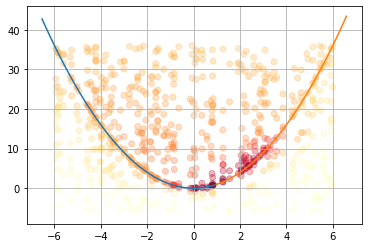

In [12]:
Plot('test2').picture(TestData.x, discriminator.model.predict(TestData.x))

In [13]:
NewData = Dataset()
NewData.load_data(data_range=12)

(array([[ 7.19725729, 51.80051249],
        [ 7.19725729, 32.7513415 ],
        [ 7.19725729, 61.88472107],
        ...,
        [-4.71135514, 80.81500559],
        [-4.71135514, 92.3447258 ],
        [-4.71135514, 38.70922713]]), array([1, 0, 0, ..., 0, 0, 0]))

In [14]:
gan = define_gan(generator.model, discriminator.model)
fit_gan(gan, NewData, 300)

Epoch 0
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 2ms/sample - loss: 3.1830
Epoch 2/2
64/64 [==============================] - 0s 156us/sample - loss: 3.1092


W1018 15:02:54.782752 23624 training.py:2197] Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


Fitting discriminator
64/64 [==============================] - 0s 249us/sample - loss: 0.3195 - acc: 0.8594
Train on 960 samples, validate on 240 samples
960/960 [==============================] - 0s 261us/sample - loss: 0.3695 - acc: 0.8625 - val_loss: 0.3471 - val_acc: 0.8708
Epoch 1
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 171us/sample - loss: 3.2484
Epoch 2/2
64/64 [==============================] - 0s 203us/sample - loss: 3.1739
Fitting discriminator
64/64 [==============================] - 0s 296us/sample - loss: 0.2505 - acc: 0.8906
Train on 960 samples, validate on 240 samples
960/960 [==============================] - 0s 256us/sample - loss: 0.3601 - acc: 0.8615 - val_loss: 0.3450 - val_acc: 0.8708
Epoch 2
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 218us/sample - loss: 3.4976
Epoch 2/2
64/64 [==============================] - 0s 265us/sample - loss: 3.4156
Fitting discriminator
64/64 [==============================] - 0s 281us/sa

Epoch 18
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 203us/sample - loss: 2.7853
Epoch 2/2
64/64 [==============================] - 0s 171us/sample - loss: 2.7079
Fitting discriminator
64/64 [==============================] - 0s 312us/sample - loss: 0.3251 - acc: 0.7969
Train on 960 samples, validate on 240 samples
960/960 [==============================] - 0s 212us/sample - loss: 0.3593 - acc: 0.8646 - val_loss: 0.3490 - val_acc: 0.8542
Epoch 19
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 234us/sample - loss: 2.1336
Epoch 2/2
64/64 [==============================] - 0s 249us/sample - loss: 2.0687
Fitting discriminator
64/64 [==============================] - 0s 296us/sample - loss: 0.3829 - acc: 0.7344
Train on 960 samples, validate on 240 samples
960/960 [==============================] - 0s 218us/sample - loss: 0.3531 - acc: 0.8656 - val_loss: 0.3481 - val_acc: 0.8542
Epoch 20
Fitting GAN
Epoch 1/2
64/64 [==============================] - 

960/960 [==============================] - 0s 217us/sample - loss: 0.3104 - acc: 0.8583 - val_loss: 0.3200 - val_acc: 0.8417
Epoch 36
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 234us/sample - loss: 1.1941
Epoch 2/2
64/64 [==============================] - 0s 249us/sample - loss: 1.1704
Fitting discriminator
64/64 [==============================] - 0s 265us/sample - loss: 0.4905 - acc: 0.7969
Train on 960 samples, validate on 240 samples
960/960 [==============================] - 0s 209us/sample - loss: 0.3159 - acc: 0.8500 - val_loss: 0.2980 - val_acc: 0.8375
Epoch 37
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 234us/sample - loss: 1.1681
Epoch 2/2
64/64 [==============================] - 0s 234us/sample - loss: 1.1484
Fitting discriminator
64/64 [==============================] - 0s 234us/sample - loss: 0.4769 - acc: 0.8281
Train on 960 samples, validate on 240 samples
960/960 [==============================] - 0s 235us/sample - loss: 0.310

64/64 [==============================] - 0s 218us/sample - loss: 0.9894
Fitting discriminator
64/64 [==============================] - 0s 374us/sample - loss: 0.4926 - acc: 0.9844
Train on 960 samples, validate on 240 samples
960/960 [==============================] - 0s 343us/sample - loss: 0.3014 - acc: 0.8573 - val_loss: 0.2897 - val_acc: 0.8458
Epoch 54
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 171us/sample - loss: 0.9797
Epoch 2/2
64/64 [==============================] - 0s 203us/sample - loss: 0.9774
Fitting discriminator
64/64 [==============================] - 0s 249us/sample - loss: 0.4851 - acc: 0.9688
Train on 960 samples, validate on 240 samples
960/960 [==============================] - 0s 213us/sample - loss: 0.3090 - acc: 0.8490 - val_loss: 0.2912 - val_acc: 0.8583
Epoch 55
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 249us/sample - loss: 0.9769
Epoch 2/2
64/64 [==============================] - 0s 452us/sample - loss: 0.9739


960/960 [==============================] - 0s 235us/sample - loss: 0.3053 - acc: 0.8344 - val_loss: 0.2933 - val_acc: 0.8458
Epoch 71
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 296us/sample - loss: 1.0538
Epoch 2/2
64/64 [==============================] - 0s 280us/sample - loss: 1.0533
Fitting discriminator
64/64 [==============================] - 0s 296us/sample - loss: 0.4397 - acc: 1.0000
Train on 960 samples, validate on 240 samples
960/960 [==============================] - 0s 266us/sample - loss: 0.2810 - acc: 0.8521 - val_loss: 0.2896 - val_acc: 0.8667
Epoch 72
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 250us/sample - loss: 1.0307
Epoch 2/2
64/64 [==============================] - 0s 467us/sample - loss: 1.0297
Fitting discriminator
64/64 [==============================] - 0s 327us/sample - loss: 0.4574 - acc: 0.9844
Train on 960 samples, validate on 240 samples
960/960 [==============================] - 0s 309us/sample - loss: 0.285

Fitting discriminator
64/64 [==============================] - 0s 218us/sample - loss: 0.4321 - acc: 1.0000
Train on 960 samples, validate on 240 samples
960/960 [==============================] - 0s 191us/sample - loss: 0.2702 - acc: 0.8469 - val_loss: 0.2819 - val_acc: 0.8667
Epoch 89
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 249us/sample - loss: 1.0353
Epoch 2/2
64/64 [==============================] - 0s 359us/sample - loss: 1.0344
Fitting discriminator
64/64 [==============================] - 0s 234us/sample - loss: 0.4546 - acc: 1.0000
Train on 960 samples, validate on 240 samples
960/960 [==============================] - 0s 191us/sample - loss: 0.2922 - acc: 0.8510 - val_loss: 0.2740 - val_acc: 0.8458
Epoch 90
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 187us/sample - loss: 1.0774
Epoch 2/2
64/64 [==============================] - 0s 296us/sample - loss: 1.0761
Fitting discriminator
64/64 [==============================] - 0s 312us/

Epoch 106
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 171us/sample - loss: 1.1386
Epoch 2/2
64/64 [==============================] - 0s 249us/sample - loss: 1.1376
Fitting discriminator
64/64 [==============================] - 0s 296us/sample - loss: 0.4030 - acc: 0.9844
Train on 960 samples, validate on 240 samples
960/960 [==============================] - 0s 188us/sample - loss: 0.2793 - acc: 0.8510 - val_loss: 0.3023 - val_acc: 0.8417
Epoch 107
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 280us/sample - loss: 1.0970
Epoch 2/2
64/64 [==============================] - 0s 296us/sample - loss: 1.0959
Fitting discriminator
64/64 [==============================] - 0s 281us/sample - loss: 0.4156 - acc: 1.0000
Train on 960 samples, validate on 240 samples
960/960 [==============================] - 0s 185us/sample - loss: 0.2713 - acc: 0.8490 - val_loss: 0.2675 - val_acc: 0.8542
Epoch 108
Fitting GAN
Epoch 1/2
64/64 [==============================]

Train on 960 samples, validate on 240 samples
960/960 [==============================] - 0s 272us/sample - loss: 0.2547 - acc: 0.8552 - val_loss: 0.2623 - val_acc: 0.8417
Epoch 124
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 390us/sample - loss: 1.1627
Epoch 2/2
64/64 [==============================] - 0s 265us/sample - loss: 1.1614
Fitting discriminator
64/64 [==============================] - 0s 265us/sample - loss: 0.3915 - acc: 1.0000
Train on 960 samples, validate on 240 samples
960/960 [==============================] - 0s 231us/sample - loss: 0.2538 - acc: 0.8604 - val_loss: 0.2608 - val_acc: 0.8417
Epoch 125
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 203us/sample - loss: 1.1221
Epoch 2/2
64/64 [==============================] - 0s 265us/sample - loss: 1.1202
Fitting discriminator
64/64 [==============================] - 0s 296us/sample - loss: 0.4084 - acc: 1.0000
Train on 960 samples, validate on 240 samples
960/960 [===============

64/64 [==============================] - 0s 156us/sample - loss: 1.2463
Fitting discriminator
64/64 [==============================] - 0s 249us/sample - loss: 0.3539 - acc: 1.0000
Train on 960 samples, validate on 240 samples
960/960 [==============================] - 0s 188us/sample - loss: 0.2666 - acc: 0.8500 - val_loss: 0.2683 - val_acc: 0.8667
Epoch 142
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 234us/sample - loss: 1.1360
Epoch 2/2
64/64 [==============================] - 0s 249us/sample - loss: 1.1341
Fitting discriminator
64/64 [==============================] - 0s 265us/sample - loss: 0.4033 - acc: 1.0000
Train on 960 samples, validate on 240 samples
960/960 [==============================] - 0s 216us/sample - loss: 0.2488 - acc: 0.8573 - val_loss: 0.2658 - val_acc: 0.8417
Epoch 143
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 140us/sample - loss: 1.2494
Epoch 2/2
64/64 [==============================] - 0s 234us/sample - loss: 1.247

960/960 [==============================] - 0s 226us/sample - loss: 0.2440 - acc: 0.8719 - val_loss: 0.2562 - val_acc: 0.8667
Epoch 159
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 218us/sample - loss: 1.1508
Epoch 2/2
64/64 [==============================] - 0s 343us/sample - loss: 1.1472
Fitting discriminator
64/64 [==============================] - 0s 203us/sample - loss: 0.3948 - acc: 1.0000
Train on 960 samples, validate on 240 samples
960/960 [==============================] - 0s 173us/sample - loss: 0.2442 - acc: 0.8729 - val_loss: 0.2665 - val_acc: 0.8667
Epoch 160
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 140us/sample - loss: 1.1465
Epoch 2/2
64/64 [==============================] - 0s 218us/sample - loss: 1.1440
Fitting discriminator
64/64 [==============================] - 0s 281us/sample - loss: 0.3958 - acc: 1.0000
Train on 960 samples, validate on 240 samples
960/960 [==============================] - 0s 206us/sample - loss: 0.2

64/64 [==============================] - 0s 249us/sample - loss: 1.1471
Fitting discriminator
64/64 [==============================] - 0s 390us/sample - loss: 0.3884 - acc: 1.0000
Train on 960 samples, validate on 240 samples
960/960 [==============================] - 0s 259us/sample - loss: 0.2384 - acc: 0.8802 - val_loss: 0.2501 - val_acc: 0.8625
Epoch 177
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 312us/sample - loss: 1.1637
Epoch 2/2
64/64 [==============================] - 0s 296us/sample - loss: 1.1615
Fitting discriminator
64/64 [==============================] - 0s 249us/sample - loss: 0.3815 - acc: 1.0000
Train on 960 samples, validate on 240 samples
960/960 [==============================] - 0s 253us/sample - loss: 0.2441 - acc: 0.8698 - val_loss: 0.2560 - val_acc: 0.8750
Epoch 178
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 265us/sample - loss: 1.1725
Epoch 2/2
64/64 [==============================] - 0s 296us/sample - loss: 1.170

960/960 [==============================] - 0s 299us/sample - loss: 0.2471 - acc: 0.8646 - val_loss: 0.2471 - val_acc: 0.8708
Epoch 194
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 140us/sample - loss: 1.1103
Epoch 2/2
64/64 [==============================] - 0s 203us/sample - loss: 1.1076
Fitting discriminator
64/64 [==============================] - 0s 312us/sample - loss: 0.4111 - acc: 0.9844
Train on 960 samples, validate on 240 samples
960/960 [==============================] - 0s 213us/sample - loss: 0.2391 - acc: 0.8740 - val_loss: 0.2485 - val_acc: 0.8625
Epoch 195
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 140us/sample - loss: 1.1682
Epoch 2/2
64/64 [==============================] - 0s 249us/sample - loss: 1.1644
Fitting discriminator
64/64 [==============================] - 0s 234us/sample - loss: 0.3806 - acc: 0.9844
Train on 960 samples, validate on 240 samples
960/960 [==============================] - 0s 221us/sample - loss: 0.2

64/64 [==============================] - 0s 156us/sample - loss: 1.1881
Fitting discriminator
64/64 [==============================] - 0s 249us/sample - loss: 0.3738 - acc: 0.9844
Train on 960 samples, validate on 240 samples
960/960 [==============================] - 0s 206us/sample - loss: 0.2332 - acc: 0.8792 - val_loss: 0.2453 - val_acc: 0.8792
Epoch 212
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 234us/sample - loss: 1.1655
Epoch 2/2
64/64 [==============================] - 0s 312us/sample - loss: 1.1636
Fitting discriminator
64/64 [==============================] - 0s 312us/sample - loss: 0.3789 - acc: 1.0000
Train on 960 samples, validate on 240 samples
960/960 [==============================] - 0s 190us/sample - loss: 0.2340 - acc: 0.8760 - val_loss: 0.2446 - val_acc: 0.8667
Epoch 213
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 249us/sample - loss: 1.2211
Epoch 2/2
64/64 [==============================] - 0s 296us/sample - loss: 1.217

960/960 [==============================] - 0s 240us/sample - loss: 0.2314 - acc: 0.8771 - val_loss: 0.2437 - val_acc: 0.8667
Epoch 229
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 187us/sample - loss: 1.1840
Epoch 2/2
64/64 [==============================] - 0s 234us/sample - loss: 1.1821
Fitting discriminator
64/64 [==============================] - 0s 421us/sample - loss: 0.3780 - acc: 0.9844
Train on 960 samples, validate on 240 samples
960/960 [==============================] - 0s 255us/sample - loss: 0.2291 - acc: 0.8781 - val_loss: 0.2562 - val_acc: 0.8583
Epoch 230
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 203us/sample - loss: 1.2311
Epoch 2/2
64/64 [==============================] - 0s 234us/sample - loss: 1.2285
Fitting discriminator
64/64 [==============================] - 0s 374us/sample - loss: 0.3547 - acc: 1.0000
Train on 960 samples, validate on 240 samples
960/960 [==============================] - 0s 192us/sample - loss: 0.2

64/64 [==============================] - 0s 171us/sample - loss: 1.2692
Fitting discriminator
64/64 [==============================] - 0s 234us/sample - loss: 0.3371 - acc: 1.0000
Train on 960 samples, validate on 240 samples
960/960 [==============================] - 0s 210us/sample - loss: 0.2311 - acc: 0.8917 - val_loss: 0.2458 - val_acc: 0.8542
Epoch 247
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 156us/sample - loss: 1.2095
Epoch 2/2
64/64 [==============================] - 0s 218us/sample - loss: 1.2077
Fitting discriminator
64/64 [==============================] - 0s 296us/sample - loss: 0.3672 - acc: 1.0000
Train on 960 samples, validate on 240 samples
960/960 [==============================] - 0s 215us/sample - loss: 0.2368 - acc: 0.8823 - val_loss: 0.2441 - val_acc: 0.8625
Epoch 248
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 234us/sample - loss: 1.2717
Epoch 2/2
64/64 [==============================] - 0s 203us/sample - loss: 1.270

960/960 [==============================] - 0s 287us/sample - loss: 0.2296 - acc: 0.8875 - val_loss: 0.2445 - val_acc: 0.8750
Epoch 264
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 218us/sample - loss: 1.2953
Epoch 2/2
64/64 [==============================] - 0s 296us/sample - loss: 1.2940
Fitting discriminator
64/64 [==============================] - 0s 358us/sample - loss: 0.3245 - acc: 1.0000
Train on 960 samples, validate on 240 samples
960/960 [==============================] - 0s 248us/sample - loss: 0.2298 - acc: 0.8771 - val_loss: 0.2411 - val_acc: 0.8708
Epoch 265
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 296us/sample - loss: 1.3123
Epoch 2/2
64/64 [==============================] - 0s 359us/sample - loss: 1.3116
Fitting discriminator
64/64 [==============================] - 0s 296us/sample - loss: 0.3202 - acc: 1.0000
Train on 960 samples, validate on 240 samples
960/960 [==============================] - 0s 250us/sample - loss: 0.2

64/64 [==============================] - 0s 187us/sample - loss: 1.2910
Fitting discriminator
64/64 [==============================] - 0s 249us/sample - loss: 0.3295 - acc: 1.0000
Train on 960 samples, validate on 240 samples
960/960 [==============================] - 0s 209us/sample - loss: 0.2293 - acc: 0.8750 - val_loss: 0.2524 - val_acc: 0.8750
Epoch 282
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 156us/sample - loss: 1.3995
Epoch 2/2
64/64 [==============================] - 0s 234us/sample - loss: 1.3987
Fitting discriminator
64/64 [==============================] - 0s 281us/sample - loss: 0.2874 - acc: 1.0000
Train on 960 samples, validate on 240 samples
960/960 [==============================] - 0s 209us/sample - loss: 0.2311 - acc: 0.8740 - val_loss: 0.2405 - val_acc: 0.8583
Epoch 283
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 203us/sample - loss: 1.3267
Epoch 2/2
64/64 [==============================] - 0s 230us/sample - loss: 1.325

960/960 [==============================] - 0s 195us/sample - loss: 0.2258 - acc: 0.8781 - val_loss: 0.2371 - val_acc: 0.8750
Epoch 299
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 156us/sample - loss: 1.3469
Epoch 2/2
64/64 [==============================] - 0s 234us/sample - loss: 1.3447
Fitting discriminator
64/64 [==============================] - 0s 265us/sample - loss: 0.3107 - acc: 1.0000
Train on 960 samples, validate on 240 samples
960/960 [==============================] - 0s 186us/sample - loss: 0.2322 - acc: 0.8771 - val_loss: 0.2517 - val_acc: 0.8625
